## Exploratory Data Analysis

Use this notebook to get familiar with the datasets we have. There is 10 questions we need to answer during the EDA.


We shouldn't limit our EDA to these 10 questions. Let's be creative :).

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from scipy import stats
from statsmodels.stats import weightstats as stests
import psycopg2
import copy
import random
import os
import requests as re
import json
from datetime import datetime, timedelta
from datetime import timezone
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn import preprocessing
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison
%matplotlib inline

In [3]:
flights = pd.read_csv('flights.csv',low_memory=False).sample(50000, random_state = 42)
flights.head(5)

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,first_dep_time,total_add_gtime,longest_add_gtime,no_name
905525,2019-02-21,B6,B6,B6,359,B6,N586JB,359,12478,JFK,...,2465,0.0,0.0,27.0,0.0,0.0,NaN,NaN,NaN,NaN
4145140,2019-12-20,DL,DL,DL,819,DL,N971AT,819,10397,ATL,...,152,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10296996,2019-03-01,WN,WN,WN,753,WN,N932WN,753,11259,DAL,...,436,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2983446,2018-12-28,WN,WN,WN,4374,WN,N8646B,4374,12191,HOU,...,192,157.0,0.0,0.0,0.0,14.0,NaN,NaN,NaN,NaN
15919188,2019-08-10,UA,UA_CODESHARE,UA,5871,OO,N118SY,5871,14771,SFO,...,710,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
flights.dtypes

fl_date                 object
mkt_unique_carrier      object
branded_code_share      object
mkt_carrier             object
mkt_carrier_fl_num       int64
op_unique_carrier       object
tail_num                object
op_carrier_fl_num        int64
origin_airport_id        int64
origin                  object
origin_city_name        object
dest_airport_id          int64
dest                    object
dest_city_name          object
crs_dep_time             int64
dep_time               float64
dep_delay              float64
taxi_out               float64
wheels_off             float64
wheels_on              float64
taxi_in                float64
crs_arr_time             int64
arr_time               float64
arr_delay              float64
cancelled                int64
cancellation_code       object
diverted                 int64
dup                     object
crs_elapsed_time       float64
actual_elapsed_time    float64
air_time               float64
flights                  int64
distance

In [6]:
df = copy.deepcopy(flights)

In [7]:
# dropping all cancelled/diverted
df = df[df['cancelled'] != 1]
df = df[df['diverted'] != 1]

In [8]:
df = flights.drop('no_name', axis = 1)

In [9]:
df = df.drop(axis = 1, labels = ['branded_code_share', 'mkt_carrier_fl_num', 'tail_num', 'op_carrier_fl_num', 'cancelled', 'cancellation_code', 'diverted', 'flights', 'first_dep_time', 'total_add_gtime', 'longest_add_gtime'])

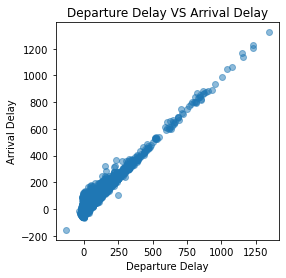

In [10]:
#correlation between delay of arrival and departue
plt.figure(figsize=(4,4))
plt.scatter(df['dep_delay'], df['arr_delay'], alpha = 0.5)
plt.title('Departure Delay VS Arrival Delay')
plt.xlabel('Departure Delay')
plt.ylabel('Arrival Delay')

plt.show()

## Task 1: Test the hypothesis that the delay is from Normal distribution. and that mean of the delay is 0. Be careful about the outliers.

In [11]:
df["arr_delay"].isnull().sum()
df.dropna(subset = ["arr_delay"], inplace = True)

In [12]:
df["arr_delay"].isnull().sum()

0

In [13]:
# dealing with outliers, False classified for values greater than 3 stand dev's from the mean
arr_delay_out = np.abs(stats.zscore(df["arr_delay"], nan_policy = 'omit'))
arr_delay_o1 = arr_delay_out <= 3

# masking the values to return 
df['arr_delay_out'] = df['arr_delay'][arr_delay_o1]

In [14]:
df['arr_delay_out'].fillna(0, inplace = True)

In [15]:
df['arr_delay_out'].isnull().sum()

0

In [16]:
delay_ar2 = df['arr_delay_out'].to_numpy()
delay_ar2

array([ 27.,   1., -20., ...,  -5.,  -9., -12.])

In [19]:
delay_ar2 = list(delay_ar2)
rand = random.sample(delay_ar2, 1000)

In [20]:
#check for normal distribution
shapiro_test = stats.shapiro(rand)
shapiro_test

ShapiroResult(statistic=0.7626890540122986, pvalue=1.2591249193704132e-35)

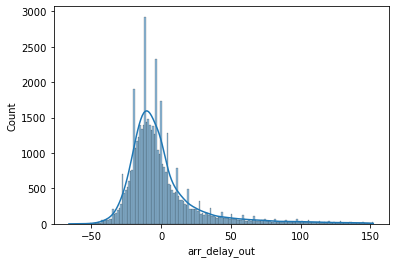

In [21]:
histplot = sns.histplot(data = df['arr_delay_out'], kde = True)

#### **Task 2**: Is average/median monthly delay different during the year? If yes, which are months with the biggest delays and what could be the reason?

In [25]:
df_2 = copy.deepcopy(flights)

In [26]:
df_2 = df_2[df_2['cancelled'] != 1]
df_2 = df_2[df_2['diverted'] != 1]

In [27]:
df_2.isnull().sum()

fl_date                    0
mkt_unique_carrier         0
branded_code_share         0
mkt_carrier                0
mkt_carrier_fl_num         0
op_unique_carrier          0
tail_num                   0
op_carrier_fl_num          0
origin_airport_id          0
origin                     0
origin_city_name           0
dest_airport_id            0
dest                       0
dest_city_name             0
crs_dep_time               0
dep_time                   0
dep_delay                 22
taxi_out                  18
wheels_off                18
wheels_on                 18
taxi_in                   18
crs_arr_time               0
arr_time                   0
arr_delay                 10
cancelled                  0
cancellation_code      49025
diverted                   0
dup                        0
crs_elapsed_time           0
actual_elapsed_time        0
air_time                  18
flights                    0
distance                   0
carrier_delay          39616
weather_delay 

In [28]:
flights_date = df_2.drop(axis = 1, labels = ['branded_code_share', 'mkt_carrier_fl_num', 'tail_num', 'op_carrier_fl_num', 'cancelled', 'cancellation_code', 'diverted', 'flights', 'first_dep_time', 'total_add_gtime', 'longest_add_gtime',
                                                            'crs_elapsed_time','actual_elapsed_time','no_name','taxi_in','taxi_out','wheels_on','wheels_off',
                                                    'mkt_unique_carrier','mkt_carrier','op_unique_carrier','distance','air_time'])

In [29]:
flights_date.dropna(subset = ["arr_delay"], inplace = True)
flights_date.dropna(subset = ["dep_delay"], inplace = True)

In [30]:
# Seperating date to (YEAR, MONTH, DAY)
flights_date['fl_date'] = pd.to_datetime(flights_date['fl_date'])
flights_date['year'] = flights_date['fl_date'].dt.year
flights_date['month'] = flights_date['fl_date'].dt.month
flights_date['date'] = flights_date['fl_date'].dt.day
# Dropping the old date column
flights_date.drop('fl_date', axis = 1, inplace = True)

In [31]:
flights_date

,origin_airport_id,origin,origin_city_name,dest_airport_id,dest,dest_city_name,crs_dep_time,dep_time,dep_delay,crs_arr_time,...,arr_delay,dup,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,year,month,date
905525,12478,JFK,"New York, NY",10800,BUR,"Burbank, CA",1654,1654.0,0.0,2025,...,27.0,N,0.0,0.0,27.0,0.0,0.0,2019,2,21
4145140,10397,ATL,"Atlanta, GA",15412,TYS,"Knoxville, TN",1342,1350.0,8.0,1433,...,1.0,N,NaN,NaN,NaN,NaN,NaN,2019,12,20
10296996,11259,DAL,"Dallas, TX",13495,MSY,"New Orleans, LA",1650,1648.0,-2.0,1815,...,-20.0,N,NaN,NaN,NaN,NaN,NaN,2019,3,1
2983446,12191,HOU,"Houston, TX",14683,SAT,"San Antonio, TX",1720,2013.0,173.0,1820,...,171.0,N,157.0,0.0,0.0,0.0,14.0,2018,12,28
15919188,14771,SFO,"San Francisco, CA",14004,PAE,"Everett, WA",1101,1052.0,-9.0,1318,...,-7.0,N,NaN,NaN,NaN,NaN,NaN,2019,8,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13207560,12892,LAX,"Los Angeles, CA",13264,MFR,"Medford, OR",1930,2000.0,30.0,2137,...,18.0,N,0.0,0.0,0.0,0.0,18.0,2019,10,10
14731227,11042,CLE,"Cleveland, OH",10397,ATL,"Atlanta, GA",600,601.0,1.0,747,...,-3.0,N,NaN,NaN,NaN,NaN,NaN,2019,6,18
6364539,14321,PWM,"Portland, ME",12478,JFK,"New York, NY",600,556.0,-4.0,724,...,-5.0,N,NaN,NaN,NaN,NaN,NaN,2018,5,31
15199323,10821,BWI,"Baltimore, MD",10792,BUF,"Buffalo, NY",1600,1558.0,-2.0,1710,...,-9.0,N,NaN,NaN,NaN,NaN,NaN,2018,3,9


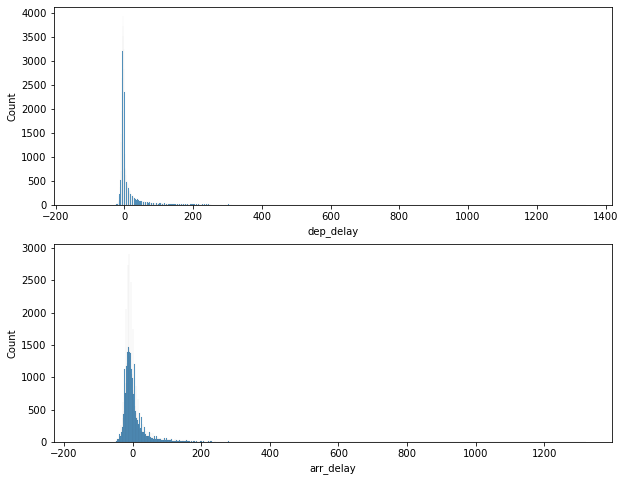

In [36]:
fig, ax = plt.subplots(2, figsize=(10,8))
sns.histplot(flights_date['dep_delay'], ax = ax[0])
sns.histplot(flights_date['arr_delay'], ax = ax[1])
plt.show()

In [37]:
flights_delay_out = flights_date.filter(['year','month','dep_delay','arr_delay'], axis=1)

<AxesSubplot:title={'center':'Average Monthly Arrival Delays'}, xlabel='month'>

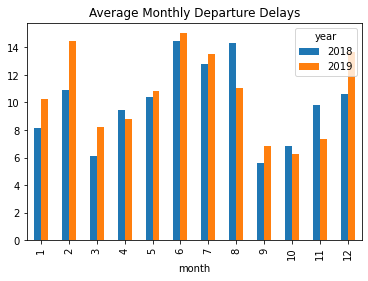

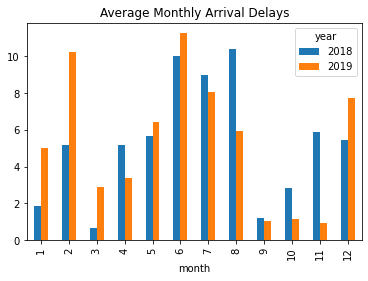

In [38]:
flights_delay_out.groupby(['year','month'])['dep_delay'].mean().unstack('year').plot.bar(title= 'Average Monthly Departure Delays')
flights_delay_out.groupby(['year','month'])['arr_delay'].mean().unstack('year').plot.bar(title= 'Average Monthly Arrival Delays')

#### **Task 3**: Does the weather affect the delay? 
Use the API to pull the weather information for flights. There is no need to get weather for ALL flights. We can choose the right representative sample. Let's focus on four weather types:
- sunny
- cloudy
- rainy
- snow.
Test the hypothesis that these 4 delays are from the same distribution. If they are not, which ones are significantly different?

In [40]:
df3 = copy.deepcopy(flights)

In [41]:
df1d = df3[(df3.cancelled == 0) & df3.dep_delay.notnull()]
x = df1d.dep_delay

In [42]:
df_3 = df3[df3.weather_delay >= 10]

In [43]:
df_3 = df_3.sort_values('weather_delay')

In [52]:
# Remove outliers
df_3 = df_3[df_3.weather_delay.between(x.quantile(.05), x.quantile(.95))]

# Pick 200? random sample
df3a = df_3.sample(n = 200)

#to populate
df3a['origin_weather'] = ""
df3a['dest_weather'] = ""

df3a = df3a[['fl_date','mkt_unique_carrier','mkt_carrier_fl_num','origin_city_name','crs_dep_time','origin_weather',
             'dest_city_name','crs_arr_time','dest_weather','weather_delay']]
df3a.head(10)

,fl_date,mkt_unique_carrier,mkt_carrier_fl_num,origin_city_name,crs_dep_time,origin_weather,dest_city_name,crs_arr_time,dest_weather,weather_delay
12353038,2018-08-03,DL,331,"New York, NY",1359,,"Atlanta, GA",1639,,24.0
283166,2019-08-23,B6,450,"Charlotte, NC",2003,,"New York, NY",2214,,26.0
3614154,2018-10-26,DL,2408,"Atlanta, GA",1922,,"Jacksonville, FL",2030,,11.0
4103840,2019-12-18,G4,2483,"Sanford, FL",1122,,"Grand Rapids, MI",1403,,11.0
8544414,2018-07-15,WN,5273,"Tampa, FL",1435,,"San Juan, PR",1735,,33.0
13354377,2019-10-16,AA,4964,"Charlotte, NC",1130,,"Erie, PA",1315,,13.0
15780717,2019-08-04,AA,5288,"Birmingham, AL",1658,,"Charlotte, NC",1936,,12.0
5494007,2019-01-22,B6,1215,"Boston, MA",1359,,"Buffalo, NY",1537,,14.0
5101855,2019-01-02,AA,1464,"Chicago, IL",926,,"Tampa, FL",1304,,16.0
8904193,2018-07-31,DL,828,"Atlanta, GA",2124,,"Scranton/Wilkes-Barre, PA",2330,,24.0


In [53]:
df3a['crs_dep_time'] = df3a['crs_dep_time'].apply(lambda x: '{0:0>4}'.format(x))
df3a['crs_arr_time'] = df3a['crs_arr_time'].apply(lambda x: '{0:0>4}'.format(x))
df3a.reset_index(inplace=True)
df3a

,index,fl_date,mkt_unique_carrier,mkt_carrier_fl_num,origin_city_name,crs_dep_time,origin_weather,dest_city_name,crs_arr_time,dest_weather,weather_delay
0,12353038,2018-08-03,DL,331,"New York, NY",1359,,"Atlanta, GA",1639,,24.0
1,283166,2019-08-23,B6,450,"Charlotte, NC",2003,,"New York, NY",2214,,26.0
2,3614154,2018-10-26,DL,2408,"Atlanta, GA",1922,,"Jacksonville, FL",2030,,11.0
3,4103840,2019-12-18,G4,2483,"Sanford, FL",1122,,"Grand Rapids, MI",1403,,11.0
4,8544414,2018-07-15,WN,5273,"Tampa, FL",1435,,"San Juan, PR",1735,,33.0
...,...,...,...,...,...,...,...,...,...,...,...
195,1290337,2018-06-11,AA,4975,"Charlotte, NC",1110,,"Charleston/Dunbar, WV",1212,,54.0
196,3331344,2018-10-13,AA,2638,"Ontario, CA",0822,,"Dallas/Fort Worth, TX",1318,,54.0
197,7432483,2018-09-24,AA,4847,"Charlotte, NC",0919,,"Jacksonville/Camp Lejeune, NC",1020,,26.0
198,10344607,2019-03-03,UA,1950,"Denver, CO",0939,,"Portland, OR",1136,,22.0


In [50]:
df3a['fl_date'] = pd.to_datetime(df3a['fl_date'], format='%Y-%m-%d').dt.strftime('%Y-%m-%d')
df3a['crs_dep_time'] = pd.to_datetime(df3a['crs_dep_time'], format='%H%M').dt.strftime('%H:%M')
df3a['crs_arr_time'] = pd.to_datetime(df3a['crs_arr_time'], format='%H%M').dt.strftime('%H:%M')

In [56]:
import requests as re
import time

def get_weather(city_name, fl_date, time):
    #Date format : 2020-08-02THH%3AMM%3ASS
    startDateTime = str(fl_date)+'T'+crs_dep_time[:2]+'%3A'+crs_dep_time[-2:]+'%3A00'
    key ='LTT3FM7JJGEKGQY5K7N8GSNMF'
    url = "https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/weatherdata/history?aggregateHours=24&combinationMethod=aggregate&startDateTime="+startDateTime+"&endDateTime="+startDateTime+"&collectStationContributions=false&maxStations=-1&maxDistance=-1&includeNormals=false&allowAsynch=true&contentType=json&unitGroup=metric&locationMode=single&key="+key+"&locations="+city_name
    res = re.get(url)
    data = json.loads(res.text) 
    try:
        return data['location']['values'][0]['conditions']
    except (KeyError):
        return data

# testing code : 
city_name=df3a.iloc[0]['dest_city_name']
fl_date=df3a.iloc[0]['fl_date']
crs_dep_time = df3a.iloc[0]['crs_arr_time']
test_request = get_weather(city_name, fl_date, time)
#str(fl_date)+'T%3A'+crs_dep_time+'T%3A00'
#str(fl_date)+'T'+crs_dep_time[:2]+'%3A'+crs_dep_time[-2:]+'%3A00'

In [57]:
test_request

'Partially cloudy'

In [58]:
#origin weather column
df3a['origin_weather'] = df3a.apply(lambda x: get_weather(x['origin_city_name'], x['fl_date'], x['crs_dep_time']), axis= 1)
df3a.head()

,index,fl_date,mkt_unique_carrier,mkt_carrier_fl_num,origin_city_name,crs_dep_time,origin_weather,dest_city_name,crs_arr_time,dest_weather,weather_delay
0,12353038,2018-08-03,DL,331,"New York, NY",1359,"Rain, Partially cloudy","Atlanta, GA",1639,,24.0
1,283166,2019-08-23,B6,450,"Charlotte, NC",2003,"Rain, Overcast","New York, NY",2214,,26.0
2,3614154,2018-10-26,DL,2408,"Atlanta, GA",1922,Overcast,"Jacksonville, FL",2030,,11.0
3,4103840,2019-12-18,G4,2483,"Sanford, FL",1122,Clear,"Grand Rapids, MI",1403,,11.0
4,8544414,2018-07-15,WN,5273,"Tampa, FL",1435,"Rain, Partially cloudy","San Juan, PR",1735,,33.0


In [59]:
#dest weather column : 
df3a['dest_weather'] = df3a.apply(lambda x: get_weather(x['dest_city_name'], x['fl_date'], x['crs_arr_time']), axis= 1)

In [60]:
df3b = pd.concat([df3a.origin_weather, df3a.dest_weather])

In [61]:
df3b.value_counts()

Rain, Partially cloudy    131
Partially cloudy           78
Rain, Overcast             71
Clear                      60
Overcast                   17
Snow, Partially cloudy     13
Snow, Overcast             13
Rain                       12
Snow                        5
dtype: int64

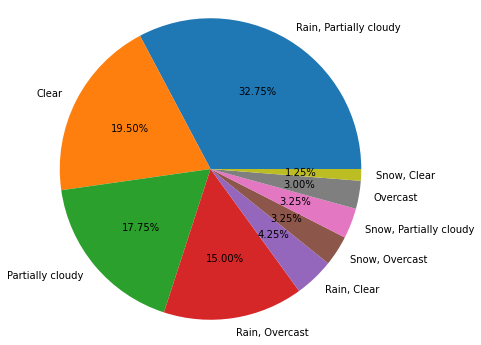

In [62]:
# Weather delay pie chart
labels = ['Rain, Partially cloudy','Clear','Partially cloudy','Rain, Overcast','Rain, Clear','Snow, Overcast','Snow, Partially cloudy','Overcast','Snow, Clear']
sizes = [df3b.value_counts()[0],
        df3b.value_counts()[1],
        df3b.value_counts()[2],
        df3b.value_counts()[3],
        df3b.value_counts()[4],
        df3b.value_counts()[5],
        df3b.value_counts()[6],
        df3b.value_counts()[7],
        df3b.value_counts()[8],]

fig1, ax1 = plt.subplots(figsize=(6,6))
ax1.pie(sizes, labels=labels, autopct='%1.2f%%')
ax1.axis('equal')
plt.show()

#### **Task 4**: How taxi times changing during the day? Does higher traffic lead to bigger taxi times?

#### **Task 5**: What is the average percentage of delays that is already created before departure? (aka are arrival delays caused by departure delays?) Are airlines able to lower the delay during the flights?

#### **Task 6**: How many states cover 50% of US air traffic? 

#### **Task 7**: Test the hypothesis whether planes fly faster when there is the departure delay? 

#### **Task 8**: When (which hour) do most 'LONG', 'SHORT', 'MEDIUM' haul flights take off?

#### **Task 9**: Find the top 10 the bussiest airports. Does the biggest number of flights mean that the biggest number of passengers went through the particular airport? How much traffic do these 10 airports cover?

#### **Task 10**: Do bigger delays lead to bigger fuel comsumption per passenger? 
We need to do four things to answer this as accurate as possible:
- Find out average monthly delay per air carrier (monthly delay is sum of all delays in 1 month)
- Find out distance covered monthly by different air carriers
- Find out number of passengers that were carried by different air carriers
- Find out total fuel comsumption per air carrier.

Use this information to get the average fuel comsumption per passenger per km. Is this higher for the airlines with bigger average delays?